In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Algorithms.learn.utils import config

# 0. Plot setting

In [2]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# 1. Model Setting

## 1.1 Load Config

In [3]:
env_kwargs, model_kwargs, learn_kwargs = config.load_config('../Algorithms/learn/tmp_config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [4]:
from Env.feature_extractor import MarketObsExtractor

model_kwargs.update({
    'buffer_size': 300,
    'learning_starts': 300,
    'batch_size': 15,
    'std_coeff': env_kwargs['cost']
})

model_kwargs['policy_kwargs'].update({
    'features_extractor_class': MarketObsExtractor
})

learn_kwargs.update({
    'total_timesteps': 1500
})

In [5]:
config.reconstruct_config(env_kwargs, model_kwargs, learn_kwargs)

env 'BSMarket was created!
model_kwargs['env']: <BSMarket instance>
env 'BSMarket was created!
learn_kwargs['eval_env']: <BSMarket instance>
learn_kwargs['tb_log_name']: ddpg_220601-1741
learn_kwargs['eval_log_path']: logs/tb_logs/ddpg_220601-1741_1


In [6]:
env_kwargs

{'cost': 0.02,
 'dividend': 0.0,
 'drift': 0.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'n_assets': 1000,
 'n_periods': 30,
 'payoff': 'european',
 'period_unit': 365,
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}

## 1.2 Construct env, model

In [7]:
from Env.env import BSMarket

env = BSMarket(**env_kwargs)

env 'BSMarket was created!


In [8]:
from Utils.prices import european_call_delta

def delta_eval(env):
    obs = env.reset()
    reward, done, info = 0, False, {}
    total_raw_reward = 0
    i = 0
    while not done:
        action = env.delta[i].copy()
        # delta = european_call_delta(obs[..., 0], obs[...,1], obs[...,2], obs[...,3])
        obs, reward, done, info = env.step(action)
        total_raw_reward += info['raw_reward']
        i += 1

    return total_raw_reward

def pnl_reward(pnl):
    mean = np.mean(pnl)
    std = np.std(pnl)
    return mean - 0.02 * std , (mean, std)

In [9]:
random_pnl = np.mean([env.pnl_eval() for _ in range(30)], axis=0)

In [12]:
delta_pnl = np.mean([delta_eval(env) for _ in range(30)], axis=0)

In [11]:
from Algorithms import DDPG

model = DDPG(**model_kwargs)
model = model.load("../Algorithms/learn/logs/tb_logs/ddpg_220531-1907_1/best_model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [13]:
rl_pnl = np.mean([env.pnl_eval(model) for _ in range(30)], axis=0)

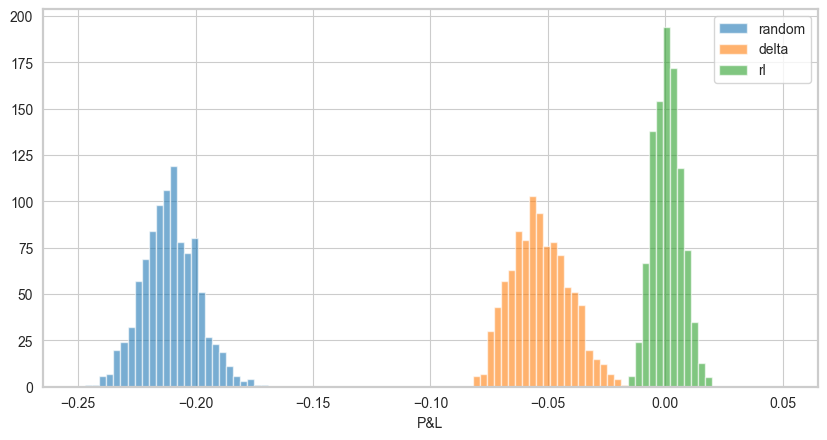

random:	-0.2112, -0.2109, 0.0117
delta:	-0.0536, -0.0534, 0.0122
rl:		0.0007, 0.0008, 0.0061
2.940153128382713
82.69192693642269


In [14]:
plt.xlabel('P&L')
plt.hist(random_pnl, bins=100, range=(-0.25, 0.05), alpha=0.6, label='random')
plt.hist(delta_pnl, bins=100, range=(-0.25, 0.05), alpha=0.6, label='delta')
plt.hist(rl_pnl, bins=100, range=(-0.25, 0.05), alpha=0.6, label='rl')
plt.legend()
plt.show()

r1, (m1, s1) = pnl_reward(random_pnl)
r2, (m2, s2) = pnl_reward(delta_pnl)
r3, (m3, s3) = pnl_reward(rl_pnl)
print(f'random:\t{r1:.4f}, {m1:.4f}, {s1:.4f}')
print(f'delta:\t{r2:.4f}, {m2:.4f}, {s2:.4f}')
print(f'rl:\t\t{r3:.4f}, {m3:.4f}, {s3:.4f}')
print((r2-r1)/abs(r2))
print((r3-r2)/abs(r3))

In [15]:
np.save('rl_pnl',rl_pnl)
np.save('delta_pnl',delta_pnl)
np.save('random_pnl',random_pnl)